# Pointer Generator over characters and tags

In [1]:
START_CHAR = '⏵'
STOP_CHAR = '⏹'
UNKNOWN_CHAR = '⊗'
UNKNOWN_TAG = '⊤'
PAD_CHAR = '₮'
PAD_TAG = '<PAD>'

In [2]:
%matplotlib inline

from itertools import zip_longest
import os
import pickle
import time

import Levenshtein
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import torch.nn.functional as F

In [3]:
def load_data(file_name):
    """Loads data.

    Args:
        file_name: path to file containing the data

    Returns:
        lemmas: list of lemma
        tags: list of tags
        inflected_forms: list of inflected form
    """

    with open(file_name, 'r', encoding='utf') as file:
        text = file.read()

    lemmas = []
    tags = []
    inflected_forms = []

    for line in text.split('\n')[:-1]:
        lemma, inflected_form, tag = line.split('\t')
        lemmas.append(lemma)
        inflected_forms.append(inflected_form)
        tags.append(tag) 

    return lemmas, tags, inflected_forms

def get_index_dictionaries(lemmas, tags, inflected_forms):
    """Returns char2index, index2char, tag2index

    Args:
        lemmas: list of lemma
        tags: list of tags
        inflected_forms: list of inflected form

    Returns: 
        char2index: a dictionary which maps character to index
        index2char: a dictionary which maps index to character
        tag2index: a ditionary which maps morphological tag to index 
    """

    unique_chars = set(''.join(lemmas) + ''.join(inflected_forms))
    unique_chars.update(START_CHAR, STOP_CHAR) # special start and end symbols
    unique_chars.update(UNKNOWN_CHAR) # special charcter for unknown word
    char2index = {}
    index2char = {}

    char2index[PAD_CHAR] = 0
    index2char[0] = PAD_CHAR
    
    for index, char in enumerate(unique_chars):
        char2index[char] = index + 1
        index2char[index + 1] = char

    unique_tags = set(';'.join(tags).split(';'))
    unique_tags.update(UNKNOWN_TAG)
    tag2index = {tag:index+1 for index, tag in enumerate(unique_tags)}
    tag2index[PAD_TAG] = 0

    return char2index, index2char, tag2index

def get_combined_index_dictionaries(lemmas, tags, inflected_forms):
    """Returns char2index, index2char

    Args:
        lemmas: list of lemma
        tags: list of tags
        inflected_forms: list of inflected form

    Returns: 
        char2index: a dictionary which maps inputs and  to index
        index2char: a dictionary which maps index to inputs
    """

    unique_chars = set(''.join(lemmas) + ''.join(inflected_forms))
    unique_chars.update(START_CHAR, STOP_CHAR, UNKNOWN_CHAR) # special start and end symbols  
    
    input2index = {}
    index2input = {}
    
    input2index[PAD_CHAR] = 0
    index2input[0] = PAD_CHAR
        
    for index, char in enumerate(unique_chars, start=1):
        input2index[char] = index
        index2input[index] = char
        
    char_vocab_length = len(input2index.keys())

    unique_tags = set(';'.join(tags).split(';'))
    unique_tags.add(UNKNOWN_TAG) # special character for unknown tags
    
    for index, char in enumerate(unique_tags, start=char_vocab_length):
        input2index[char] = index
        index2input[index] = char

    return input2index, index2input, char_vocab_length

def words_to_indices(words, char2index, tensor=False, start_char=False, stop_char=False):
    """Converts list of words to a list with list containing indices

    Args:
        words: list of words
        char2index: dictionary which maps character to index
        tensor: if to return a list of tensor  

    Returns:
        tensor: list of list/tensor containing indices for a sequence of characters
    """

    list_indices = []
    for word in words:
        word_indices = []
        if start_char:
            word_indices.append(char2index[START_CHAR])
        for char in word:
            if char in char2index.keys():
                word_indices.append(char2index[char])
            else:
                word_indices.append(char2index[UNKNOWN_CHAR])
        if stop_char:
            word_indices.append(char2index[STOP_CHAR])
        if tensor:
            word_indices = torch.Tensor(word_indices)
        list_indices.append(word_indices)

    return list_indices

def tag_to_vector(tags, tag2index):
    """Returns one hot representation of tags given a tag.

    Args:
        tags: list of string representation of tag (eg, V;IND;PRS;2;PL)

    Returns:
        tag_vectors: list of 1D tensors with one hot representation of tags 
    """

    tag_vectors = []
    for tag in tags:
        tag_vector = torch.zeros(len(tag2index))
        for tag_feature in tag.split(';'):
            if tag_feature in tag2index:
                tag_vector[tag2index[tag_feature]] = 1
            else:
                tag_vector[tag2index[UNKNOWN_TAG]] = 1
        tag_vectors.append(tag_vector)
    return tag_vectors

def tag_to_indices(tags, tag2index):
    """Converts list of tags to a list of lists containing indices

    Args:
        words: list of tags

    Returns:
        tensor: list of list containing indices of sub_tags
    """
    
    list_indices = []
    for tag in tags:
        tag_indices = []
        for sub_tag in tag.split(';'):
            if sub_tag in tag2index.keys():
                tag_indices.append(tag2index[sub_tag])
            else:
                tag_indices.append(tag2index[UNKNOWN_TAG])
        list_indices.append(tag_indices)

    return list_indices
    

def indices_to_word(indices, index2char):
    """Returns a word given list contaning indices of words

    Args:
        indices: list containing indices

    Returns:
        word: a string
    """

    return ''.join([index2char[index] for index in indices])[:-1]

def pad_lists(lists, pad_int, pad_len=None):
    """Pads lists in a list to make them of equal size"""
    
    if pad_len is None:
        pad_len = max([len(lst) for lst in lists])
    new_list = []
    for lst in lists:
        if len(lst) < pad_len:
            new_list.append(torch.tensor(lst + [pad_int] * (pad_len-len(lst))))
        else:
            new_list.append(torch.tensor(lst[:pad_len]))
    return torch.stack(new_list)

def merge_lists(lists1, lists2):
    """Add two list of lists."""
    
    merged_lists = []
    for list1, list2 in zip(lists1, lists2):
        merged_lists.append(list1 + list2)
    return merged_lists

def grouper(iterable, n, fillvalue=None):
    "Collect data into fixed-length chunks or blocks"
    # grouper('ABCDEFG', 3, 'x') --> ABC DEF Gxx"
    args = [iter(iterable)] * n
    return zip_longest(*args, fillvalue=fillvalue)

def accuracy(predictions, targets):
    correct_count = 0
    for prediction, target in zip(predictions, targets):
        if prediction == target:
            correct_count += 1
    return correct_count / len(predictions)

def average_distance(predictions, targets):
    total_distance = 0
    for prediction, target in zip(predictions, targets):
        total_distance += Levenshtein.distance(prediction, target)
    return total_distance / len(predictions)

def evaluate(predictions, targets):
    return accuracy(predictions, targets), average_distance(predictions, targets)

In [4]:
language = 'middle-french'
dataset = 'high'

In [5]:
lemmas, tags, inflected_forms = load_data('./conll2018/task1/all/{}-train-{}'.format(language, dataset))

In [6]:
lemmas_train, lemmas_val, tags_train, tags_val, inflected_forms_train, inflected_forms_val = train_test_split(lemmas, tags, inflected_forms, test_size=0.2, random_state=42)

In [7]:
input2index, index2input, char_vocab_size = get_combined_index_dictionaries(lemmas_train, tags_train, inflected_forms_train)


# Train

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
batch_size = 32
embedding_size = 300
hidden_size = 100
input_vocab_size = len(index2input.keys())

    class Attention(nn.Module):
        def __init__(self, hidden_size):
            # Custom

            super(Attention, self).__init__()
            self.linear = nn.Linear(3*hidden_size, 1)

        def forward(self, encoded_input, hidden_state, input_mask):
            src_len = encoded_input.shape[1]
            concat = torch.cat([encoded_input, hidden_state.transpose(0, 1).expand(-1, src_len, -1)], dim=2)
            attn_weights = F.tanh(self.linear(concat).squeeze())

            input_mask = input_mask.float()
            input_mask = torch.where(input_mask == 0, torch.zeros_like(input_mask), torch.ones_like(input_mask) * float('inf'))
            attn_weights = attn_weights - input_mask
            # attn_weights.data.masked_fill_(input_mask, float('-inf'))

            attn_weights = F.softmax(attn_weights, dim=1)
            return attn_weights

    class Attention(nn.Module):
        def __init__(self, hidden_size, intermediate_size=100):
            # concat scoring function - global attention 
            # https://arxiv.org/pdf/1508.04025.pdf

            super(Attention, self).__init__()
            if intermediate_size is None:
                intermediate_size = int(attention_input_size ** (1/2))
            self.W_a = nn.Linear(3*hidden_size, intermediate_size, bias=False)
            self.v_a = nn.Linear(intermediate_size, 1, bias=False)

        def forward(self, encoded_input, hidden_state, input_mask):
            src_len = encoded_input.shape[1]
            concat = torch.cat([encoded_input, hidden_state.transpose(0, 1).expand(-1, src_len, -1)], dim=2)
            attn_weights = F.tanh(self.W_a(concat))
            attn_weights = self.v_a(attn_weights).squeeze()
            attn_weights.data.masked_fill_(input_mask, float('-inf'))
            attn_weights = F.softmax(attn_weights, dim=1)
            return attn_weights

In [10]:
class Attention(nn.Module):
    def __init__(self, hidden_size, p=0.3):
        # general scoring function - global attention 
        # https://arxiv.org/pdf/1508.04025.pdf

        super(Attention, self).__init__()
        self.W_a = nn.Linear(2*hidden_size, hidden_size, bias=False)
        # self.dropout = nn.Dropout(p)

    def forward(self, encoded_input, hidden_state, input_mask):
        src_len = encoded_input.shape[1]
        attn_weights = torch.bmm(self.W_a(encoded_input), hidden_state.transpose(0, 1).transpose(1, 2)).squeeze()
        attn_weights.data.masked_fill_(input_mask, float('-inf'))
        # attn_weights = dropout(attn_weights)
        attn_weights = F.softmax(attn_weights, dim=1)
        return attn_weights

    class Attention(nn.Module):
        def __init__(self, attention_input_size, intermediate_size=100):
            super(Attention, self).__init__()

        def forward(self, encoded_input, hidden_state, input_mask):
            src_len = encoded_input.shape[1]
            attn_weights = (encoded_input * torch.cat([hidden_state.transpose(0, 1).expand(-1, src_len, -1), hidden_state.transpose(0, 1).expand(-1, src_len, -1)], dim=2)).sum(dim=2)

            input_mask = input_mask.float()
            input_mask = torch.where(input_mask == 0, torch.zeros_like(input_mask), torch.ones_like(input_mask) * float('inf'))
            attn_weights = attn_weights - input_mask
            #attn_weights.masked_fill_(input_mask, float('-inf'))

            attn_weights = F.softmax(attn_weights, dim=1)
            return attn_weights

In [11]:
class GenerationProbability(nn.Module):
    def __init__(self, embedding_size, hidden_size):
        super(GenerationProbability, self).__init__()
        self.linear_context = nn.Linear(2*hidden_size, 1)
        self.linear_hidden = nn.Linear(hidden_size, 1)
        self.linear_input = nn.Linear(embedding_size, 1)
        
    def forward(self, context, hidden_state, decoder_input):
        return F.sigmoid(self.linear_context(context) + self.linear_hidden(hidden_state.squeeze()) + self.linear_input(decoder_input))

In [12]:
Embedder = nn.Embedding(input_vocab_size, embedding_size, padding_idx=input2index[PAD_CHAR]).to(device)
Encoder = nn.LSTM(embedding_size, hidden_size, batch_first=True, bidirectional=True).to(device)
attention = Attention(hidden_size).to(device)
Decoder = nn.LSTM(embedding_size + 2 * hidden_size, hidden_size, batch_first=True).to(device)
linear_vocab = nn.Linear(3 * hidden_size, char_vocab_size - 1).to(device) # remove pad character option
generation_prob = GenerationProbability(embedding_size, hidden_size).to(device)
log_softmax = nn.LogSoftmax(dim=2).to(device)
criterion = nn.NLLLoss(ignore_index=-1)
params = list(Embedder.parameters()) + list(Encoder.parameters()) + list(Decoder.parameters()) + \
        list(linear_vocab.parameters())+ list(attention.parameters()) + list(generation_prob.parameters())

In [13]:
def test(lemmas_val, tags_val, inflected_forms_val, batch_size=32, attn_debug=False, max_pred_len=25):
    max_pred_len = 25

    inflected_predicted = []
    inflected_forms_true = []
    if attn_debug:
        input_seq = []
        attn_weights_all = []
        p_gen_all = []
    output_indices = []

    for batch in grouper(zip(lemmas_val, tags_val, inflected_forms_val), batch_size):
        batch = list(filter(lambda x: x is not None, batch))
        lemmas, tags, inflected_forms = zip(*batch)

        lemmas_indices = words_to_indices(lemmas, input2index, start_char=True, stop_char=True)
        tags_indices = tag_to_indices(tags, input2index)    
        input_indices = merge_lists(lemmas_indices, tags_indices)

        # Sort by length of input sequence
        input_indices, inflected_forms = zip(*sorted(zip(input_indices, inflected_forms), key=lambda x: len(x[0]), reverse=True))        
        if attn_debug:
            input_seq += [[index2input[index] for index in input_indices1] for input_indices1 in input_indices]
        input_indices = [torch.tensor(lst) for lst in input_indices]

        input_tensor = pad_sequence(input_indices, padding_value=input2index[PAD_CHAR], batch_first=True).to(device)
        embedding = Embedder(input_tensor)
        lengths = [Tensor.shape[0] for Tensor in input_indices]
        packed_input = pack_padded_sequence(embedding, lengths, batch_first=True)
        encoded_packed_seq, (hidden, cell) = Encoder(packed_input)
        encoded_input = pad_packed_sequence(encoded_packed_seq, batch_first=True)[0]

        input_mask = input_tensor == 0
        # input_mask = torch.where(input_mask > 0, torch.zeros_like(input_mask), torch.ones_like(input_mask) * float('inf')) 


        # Decode
        hidden_state = hidden[0,:,:] + hidden[1,:,:]
        hidden_state = hidden_state.unsqueeze(0)
        cell_state = torch.zeros(1, len(lengths), hidden_size).to(device)

        decoder_input = torch.tensor([input2index[START_CHAR]] * len(lengths)).to(device)
        decoder_input = Embedder(decoder_input)


        outputs = []
        attn_weights_sequence = []
        p_gen_seq = []
        for seq in range(0, max_pred_len):
            attn_weights = attention(encoded_input, hidden_state, input_mask)
            context = torch.bmm(attn_weights.unsqueeze(1), encoded_input).squeeze()

            decoder_input_concat = torch.cat([context, decoder_input], dim=1)

            output, (hidden_state, cell_state) = Decoder(decoder_input_concat.unsqueeze(1), (hidden_state, cell_state))
            p_vocab = F.relu(linear_vocab(torch.cat([hidden_state, context.unsqueeze(0)], dim=2)))    
            p_vocab = F.softmax(p_vocab.squeeze(), dim=1)
            p_gen = generation_prob(context, hidden_state, decoder_input)
            p_atten = torch.zeros(attn_weights.shape[0], len(input2index)).to(device)
            p_atten.scatter_add_(1, input_tensor, attn_weights)
            p_w = p_gen * p_vocab + (1 - p_gen) * p_atten[:, 1:char_vocab_size]
            decoder_input = Embedder(p_w.argmax(dim=1) + 1)
            outputs.append(p_w)
            if attn_debug:
                attn_weights_sequence.append(attn_weights)
                p_gen_seq.append(p_gen)

        if attn_debug:
            attn_weights_sequence = torch.stack(attn_weights_sequence, dim=1)
            attn_weights_all.append(attn_weights_sequence)
            p_gen_all.append(torch.cat(p_gen_seq, dim=1))
        output_indices.append(torch.stack(outputs).argmax(dim=2))
        inflected_forms_true += inflected_forms

    output_indices = torch.cat(output_indices, dim=1).transpose(0, 1).cpu().numpy()
    for indices in output_indices:
        inflected_predicted.append(''.join([index2input[index + 1] for index in indices]).split(STOP_CHAR)[0])

    if attn_debug:
        max_src_len = max([x.shape[2] for x in attn_weights_all])
        for i in range(len(attn_weights_all)):
            attn_weights = attn_weights_all[i]
            batch_size = attn_weights.shape[0]
            src_len = attn_weights.shape[2]
            attn_weights_all[i] = torch.zeros(batch_size, max_pred_len, max_src_len)
            attn_weights_all[i][:,:,:src_len] = attn_weights
        attn_weights_all = torch.cat(attn_weights_all, dim=0)
        p_gen_all = torch.cat(p_gen_all, dim=0)
        return inflected_predicted, input_seq, attn_weights_all, p_gen_all
    else:
        return inflected_predicted, inflected_forms_true

In [14]:
def train(lemmas_train, tags_train, inflected_forms_train, epochs=1):
    start_time = time.time()
    
    for epoch in range(epochs):

        epoch_loss = 0

        for batch in grouper(zip(lemmas_train, tags_train, inflected_forms_train), batch_size):
            batch = list(filter(lambda x: x is not None, batch))
            lemmas, tags, inflected_forms = zip(*batch)


            lemmas_indices = words_to_indices(lemmas, input2index, start_char=True, stop_char=True)
            tags_indices = tag_to_indices(tags, input2index)    
            inflected_forms_indices = words_to_indices(inflected_forms, input2index)
            input_indices = merge_lists(lemmas_indices, tags_indices)

            # Sort by length of input sequence
            input_indices, inflected_forms_indices = zip(*sorted(zip(input_indices, inflected_forms_indices), key=lambda x: len(x[0]), reverse=True))
            input_indices = [torch.tensor(lst) for lst in input_indices]

            optimiser.zero_grad()

            input_tensor = pad_sequence(input_indices, padding_value=input2index[PAD_CHAR], batch_first=True).to(device)
            embedding = Embedder(input_tensor)
            lengths = [Tensor.shape[0] for Tensor in input_indices]
            packed_input = pack_padded_sequence(embedding, lengths, batch_first=True)
            encoded_packed_seq, (hidden, cell) = Encoder(packed_input)
            encoded_input = pad_packed_sequence(encoded_packed_seq, batch_first=True)[0]

            input_mask = input_tensor == 0
            # input_mask = torch.where(input_mask > 0, torch.zeros_like(input_mask), torch.ones_like(input_mask) * float('inf')) 

            # Decode
            hidden_state = hidden[0,:,:] + hidden[1,:,:]
            hidden_state = hidden_state.unsqueeze(0)
            cell_state = torch.zeros(1, len(lengths), hidden_size).to(device)

            target = pad_lists([lst + [input2index[STOP_CHAR]] for lst in inflected_forms_indices], input2index[PAD_CHAR]).to(device)    
            target = target - 1

            decoder_input = pad_lists(inflected_forms_indices, input2index[PAD_CHAR]).to(device)
            decoder_input = torch.cat([torch.tensor([input2index[START_CHAR]] * len(lengths)).unsqueeze(1).to(device), decoder_input], dim=1)
            decoder_input = Embedder(decoder_input)

            loss = 0

            max_length = target.shape[1]
            for seq in range(0, max_length):
                attn_weights = attention(encoded_input, hidden_state, input_mask)
                context = torch.bmm(attn_weights.unsqueeze(1), encoded_input).squeeze()

                decoder_input_concat = torch.cat([context.unsqueeze(1), decoder_input[:,seq,:].unsqueeze(1)], dim=2)

                output, (hidden_state, cell_state) = Decoder(decoder_input_concat, (hidden_state, cell_state))
                p_vocab = F.relu(linear_vocab(torch.cat([hidden_state, context.unsqueeze(0)], dim=2)))
                p_vocab = F.softmax(p_vocab.squeeze(), dim=1)

                p_gen = generation_prob(context, hidden_state, decoder_input[:,seq,:])
                p_atten = torch.zeros(attn_weights.shape[0], len(input2index)).to(device)
                p_atten.scatter_add_(1, input_tensor, attn_weights)
                p_w = p_gen * p_vocab + (1 - p_gen) * p_atten[:, 1:char_vocab_size]

                p_w = torch.log(p_w)
                loss += criterion(p_w, target[:,seq])

                epoch_loss += loss.item()
            loss.backward()
            optimiser.step()
        print("Epoch: {}/{}\tTime: {:.2f}s\tLoss: {:.4f}\tAccuracy: {:.4f}\tDistance: {:.4f} ".format(epoch+1, epochs, time.time() - start_time, epoch_loss / len(lemmas_train), *evaluate(*test(lemmas_val, tags_val, inflected_forms_val))))

In [15]:
optimiser = optim.Adagrad(params, lr=0.1)

In [16]:
%prun train(lemmas_train, tags_train, inflected_forms_train, epochs=50)

Epoch: 1/50	Time: 10.53s	Loss: 7.3870	Accuracy: 0.0205	Distance: 5.1515 
Epoch: 2/50	Time: 22.55s	Loss: 3.9669	Accuracy: 0.1060	Distance: 4.3375 
Epoch: 3/50	Time: 35.04s	Loss: 2.8955	Accuracy: 0.1605	Distance: 3.4315 
Epoch: 4/50	Time: 47.03s	Loss: 2.2719	Accuracy: 0.3050	Distance: 2.8590 
Epoch: 5/50	Time: 59.19s	Loss: 2.0150	Accuracy: 0.3120	Distance: 2.6380 
Epoch: 6/50	Time: 71.13s	Loss: 1.6915	Accuracy: 0.3940	Distance: 2.0190 
Epoch: 7/50	Time: 82.87s	Loss: 1.4067	Accuracy: 0.4450	Distance: 1.7955 
Epoch: 8/50	Time: 95.65s	Loss: 1.1772	Accuracy: 0.4975	Distance: 1.6325 
Epoch: 9/50	Time: 108.17s	Loss: 1.0138	Accuracy: 0.5700	Distance: 1.3630 
Epoch: 10/50	Time: 120.68s	Loss: 0.8866	Accuracy: 0.5970	Distance: 1.1500 
Epoch: 11/50	Time: 132.85s	Loss: 0.8830	Accuracy: 0.6065	Distance: 1.1870 
Epoch: 12/50	Time: 145.02s	Loss: 0.7841	Accuracy: 0.6100	Distance: 1.1420 
Epoch: 13/50	Time: 157.71s	Loss: 0.8562	Accuracy: 0.6080	Distance: 1.2995 
Epoch: 14/50	Time: 170.80s	Loss: 0.7491	Ac

KeyboardInterrupt: 

In [ ]:
optimiser = optim.Adagrad(params, lr=0.01)

In [ ]:
train(lemmas_train, tags_train, inflected_forms_train, epochs=30)

In [ ]:
optimiser = optim.Adagrad(params, lr=0.01)

In [ ]:
train(lemmas_train, tags_train, inflected_forms_train, epochs=1000)

In [ ]:
print("Train accuracy:", evaluate(*test(lemmas_train, tags_train, inflected_forms_train)), "Validation accuracy: ", evaluate(*test(lemmas_val, tags_val, inflected_forms_val)))

# Visualising

In [17]:
pred, input_seq, attn_weights, p_gens = test(lemmas_val[:100], tags_val[:100], inflected_forms_val[:100], batch_size=32, attn_debug=True)

In [23]:
p_gens[1]

tensor([ 0.9714,  1.0000,  1.0000,  1.0000,  0.9998,  1.0000,  1.0000,
         0.9999,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000], device='cuda:0')

In [21]:
def showAttention(input_sentence, output_words, attentions, font=None):
    # https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
        
    # Set up figure with colorbar
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions, cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    font = FontProperties(fname=font, size=24)
    ax.set_xticklabels([''] + input_sentence, rotation=90, fontproperties=font)
    ax.set_yticklabels([''] + output_words, fontproperties=font)
    ax.tick_params(axis='both', which='major', pad=15)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

X: axis: ⏵, t, o, u, r, n, o, y, e, r, ⏹, V, 1, PL, SBJV, PST, IPFV
Y: axis: t, o, u, r, n, o, y, a, s, s, i, o, n, s tournoyassions
Correct:  tournoyassions


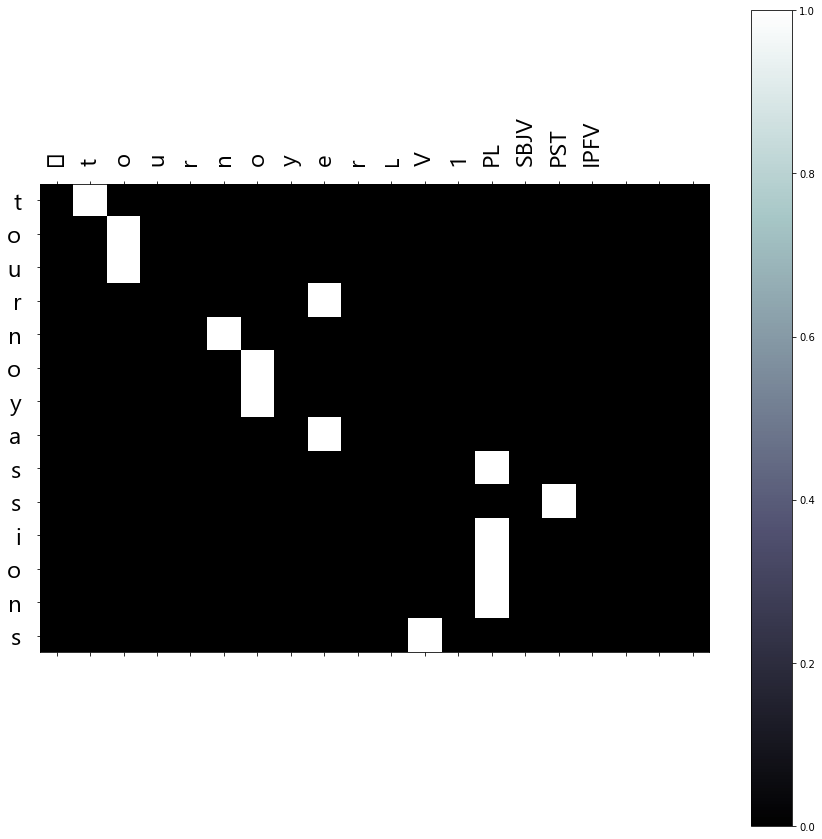

In [22]:
i = 1
print('X: axis:', ', '.join(list(input_seq[i])))
print('Y: axis:', ', '.join(list(pred[i])), pred[i])
print("Correct: ", inflected_forms_val[lemmas_val.index(''.join(input_seq[i])[1:].split(STOP_CHAR)[0])])
showAttention(input_seq[i], list(pred[i]), attn_weights[i, :len(pred[i])].cpu().detach().numpy(), 'Nirmala.ttf')

In [ ]:
#list(zip(*test(lemmas_val, tags_val, inflected_forms_val)))

# Development Dataset

In [24]:
lemmas_dev, tags_dev, inflected_forms_dev = load_data('./conll2018/task1/all/{}-dev'.format(language))

In [25]:
evaluate(*test(lemmas_dev, tags_dev, inflected_forms_dev))

(0.741, 0.746)

Hindi/high - (0.765, 0.782), Initial LR: 0.1, very different results on different initialisations  
Middle-French/high - (0.873, 0.365) - Probability of generation always one. 

In [ ]:
for prediction, truth in zip(*test(lemmas_dev, tags_dev, inflected_forms_dev)):
    if prediction != truth:
        print("Prediction: {}\tTruth: {}".format(prediction, truth))